In [54]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.utils import class_weight
import numpy as np
import seaborn as sns

In [46]:
# Configuración de rutas
base_dir = 'data'  # Reemplaza con la ruta principal donde están train, test, valid
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
valid_dir = os.path.join(base_dir, 'valid')

In [45]:
# Generador de datos con normalización y aumento ajustado para el entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,  # Reducir rotación
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,  # Añadir flips verticales si es necesario
    brightness_range=[0.9, 1.1],  # Reducir el rango de brillo
    fill_mode='nearest'
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Crear los generadores
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True  # ACTIVAR SHUFFLE para mezclar los datos en cada época
)

validation_generator = valid_test_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # No es necesario mezclar en validación
)

test_generator = valid_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Mantener False para evitar desalineación
)

Found 23214 images belonging to 2 classes.
Found 3736 images belonging to 2 classes.
Found 5436 images belonging to 2 classes.


In [63]:
# Cargar el modelo base (DenseNet121)
from tensorflow.keras.applications import DenseNet121

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Descongelar las últimas capas del modelo base DenseNet121
base_model.trainable = True
for layer in base_model.layers[:-50]:  # Descongelar solo las últimas 50 capas
    layer.trainable = False

In [65]:
# Añadir capas superiores personalizadas con regularización L2 y Dropout adicional
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation='softmax')(x)  # Capa final con 2 clases

# Crear el modelo completo
model = models.Model(inputs=base_model.input, outputs=outputs)

# Compilar el modelo con tasa de aprendizaje inicial ajustada
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(name='auc')])

# Mostrar la arquitectura del modelo
model.summary()

# Configurar los pasos por época basados en el tamaño de datos y batch size
steps_per_epoch = int(np.ceil(train_generator.samples / train_generator.batch_size))
validation_steps = int(np.ceil(validation_generator.samples / validation_generator.batch_size))

# Guardar el mejor modelo durante el entrenamiento
checkpoint_path = 'models/best_melanomaornot_model_02.keras'
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_auc',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

# Parar temprano si no hay mejora
early_stopping = EarlyStopping(monitor='val_auc', patience=8, verbose=1, restore_best_weights=True, mode='max')

# Reducir la tasa de aprendizaje si no hay mejora
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=4, verbose=1, min_lr=1e-7, mode='max')



Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_20   │ (None, 230, 230,  │          0 │ input_layer_10[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_21   │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_2… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,694,146 (29.35 MB)

 Trainable params: 1,732,290 (6.61 MB)

 Non-trainable params: 5,961,856 (22.74 MB)

In [67]:
# Registrar el historial de entrenamiento para reanudarlo en caso de interrupción
csv_logger = CSVLogger('training_log.csv', append=True)

# Callback personalizado para calcular AUC-ROC en cada época
class RocAucCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_pred = self.model.predict(validation_generator)
        val_true = validation_generator.classes
        auc = roc_auc_score(val_true, val_pred[:, 1])
        print(f'Epoch {epoch + 1} - val_auc: {auc:.4f}')

# Calcular los pesos de las clases basado en el número de muestras
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Si tienes un modelo guardado pero solo deseas cargar el modelo base (sin capas densas superiores):
if os.path.exists(checkpoint_path):
    try:
        # Cargar los pesos del modelo base (DenseNet121), omitir las capas superiores
        base_model.load_weights(checkpoint_path)
        print(f"Modelo base cargado desde {checkpoint_path}")
    except ValueError as e:
        print(f"No se pudieron cargar algunos pesos del modelo base: {str(e)}")

Modelo base cargado desde models/best_melanomaornot_model_02.keras


In [68]:
# Entrenar el modelo desde cero (sin intentar cargar pesos de capas superiores)
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=30,
    callbacks=[checkpoint, early_stopping, reduce_lr, csv_logger, RocAucCallback()],
    class_weight=dict(enumerate(class_weights))
)

Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  7/726 ━━━━━━━━━━━━━━━━━━━━ 41:26 3s/step - accuracy: 0.4545 - auc: 0.5201 - loss: 2.0088

111/111 ━━━━━━━━━━━━━━━━━━━━ 309s 3s/step - accuracy: 0.9841 - loss: 0.3226
Test Loss: 0.364154189825058
Test Accuracy: 0.9648085832595825
112/112 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step
AUC-ROC: 1.00
Predictions shape: (3561, 2)
Predicted classes length: 3561
True classes length: 3561
              precision    recall  f1-score   support

    Melanoma       0.94      0.99      0.97      1781
 NotMelanoma       0.99      0.94      0.96      1780

    accuracy                           0.96      3561
   macro avg       0.97      0.96      0.96      3561
weighted avg       0.97      0.96      0.96      3561



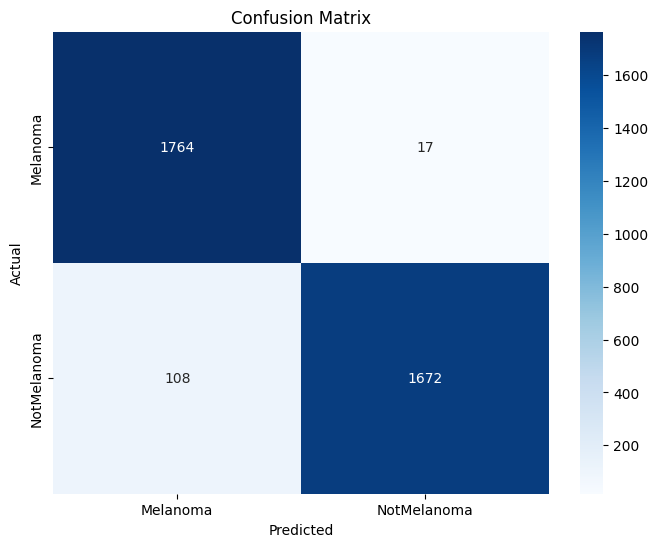

In [46]:
# Evaluar el modelo en el conjunto de pruebas
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Calcular el número de steps exactos para cubrir todas las muestras
steps = int(np.ceil(test_generator.samples / test_generator.batch_size))

# Calcular las predicciones con el número de steps correcto
predictions = model.predict(test_generator, steps=steps, verbose=1)

# Asegúrate de que no falten imágenes al final del proceso
predicted_classes = np.argmax(predictions, axis=1)

# Comparar las longitudes de true_classes y predicted_classes
true_classes = test_generator.classes
assert len(true_classes) == len(predicted_classes), "Mismatch in number of predictions and true labels"

# Calcular AUC-ROC
auc = roc_auc_score(true_classes, predictions[:, 1])
print(f'AUC-ROC: {auc:.2f}')

# Generar el reporte de clasificación
class_labels = list(test_generator.class_indices.keys())
if len(true_classes) == len(predicted_classes):
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(report)
else:
    print("Las longitudes de true_classes y predicted_classes no coinciden. No se puede generar el reporte.")

# Mostrar la matriz de confusión
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [49]:
# Guardar el modelo actualizado
model.save('models/melanoma_3.keras')